Events Keys:
runNumber
eventNumber
lumiBlock
coreFlags
mcEventNumber
mcChannelNumber
mcEventWeight
nTruthPart
G4PreCalo_n_EM
G4PreCalo_E_EM
G4PreCalo_n_Had
G4PreCalo_E_Had
truthVertexX
truthVertexY
truthVertexZ
truthPartPdgId
truthPartStatus
truthPartBarcode
truthPartPt
truthPartE
truthPartMass
truthPartEta
truthPartPhi
nTrack
trackID
trackPt
trackP
trackMass
trackEta
trackPhi
trackTruthParticleIndex
trackVisibleCalHitCaloEnergy
trackFullCalHitCaloEnergy
trackSubtractedCaloEnergy
trackNumberOfPixelHits
trackNumberOfSCTHits
trackNumberOfPixelDeadSensors
trackNumberOfSCTDeadSensors
trackNumberOfPixelSharedHits
trackNumberOfSCTSharedHits
trackNumberOfPixelHoles
trackNumberOfSCTHoles
trackNumberOfInnermostPixelLayerHits
trackNumberOfNextToInnermostPixelLayerHits
trackExpectInnermostPixelLayerHit
trackExpectNextToInnermostPixelLayerHit
trackNumberOfTRTHits
trackNumberOfTRTOutliers
trackChiSquared
trackNumberDOF
trackD0
trackZ0
trackEta_PreSamplerB
trackPhi_PreSamplerB
trackEta_PreSamplerE
t

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



        {'ID': 757184104, 'X': 660.9131469726562, 'Y': -1388.8629150390625, 'Z': -1135.1710205078125, 'E': 0.006981792859733105, 'eta': -0.6835479736328125, 'phi': -1.1266413927078247}
        {'ID': 757184616, 'X': 660.9131469726562, 'Y': -1388.8629150390625, 'Z': -1141.150146484375, 'E': 0.019941238686442375, 'eta': -0.6866728663444519, 'phi': -1.1266413927078247}
        {'ID': 757185128, 'X': 660.9131469726562, 'Y': -1388.8629150390625, 'Z': -1147.1405029296875, 'E': 0.009026993997395039, 'eta': -0.6897977590560913, 'phi': -1.1266413927078247}
        {'ID': 757185640, 'X': 660.9131469726562, 'Y': -1388.8629150390625, 'Z': -1153.14208984375, 'E': 0.011031022295355797, 'eta': -0.6929226517677307, 'phi': -1.1266413927078247}
        {'ID': 757188198, 'X': 521.8433837890625, 'Y': -1446.968017578125, 'Z': -1183.3203125, 'E': 0.03408834710717201, 'eta': -0.7085098624229431, 'phi': -1.2246688604354858}
        {'ID': 757188710, 'X': 521.8433837890625, 'Y': -1446.968017578125, 'Z': -1189.

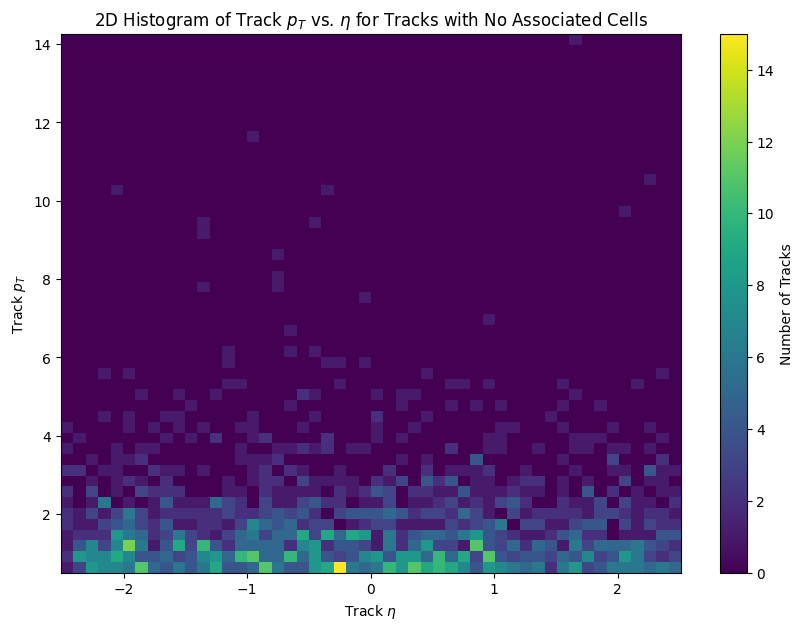

In [6]:
import uproot
import awkward as ak
import numpy as np
import vector
import sys
import matplotlib.pyplot as plt
sys.path.append("/home/mjovanovic/Work/PointNet_Segmentation")
from utils.track_metadata import calo_layers, has_fixed_r, fixed_r, fixed_z  # Assuming these are correctly defined
HAS_FIXED_R, FIXED_R, FIXED_Z = has_fixed_r, fixed_r, fixed_z

# Path to the ROOT file containing jet events
FILE_LOC = "/fast_scratch_1/atlas_images/jets/mltree_JZ1_0_5000events.root"
GEO_FILE_LOC = "/data/atlas/data/rho_delta/rho_small.root"



# Maximum distance for cell and track identification
MAX_DISTANCE = 1.6

# Open the ROOT file and access the EventTree
events = uproot.open(FILE_LOC + ":EventTree")
cellgeo = uproot.open(GEO_FILE_LOC + ":CellGeo")

print("Events Keys:")
for key in events.keys():
    print(key)

print("\nGeometry Keys:")
for key in cellgeo.keys():
    print(key)

'''
Done:
- Load in dataset
- Get track x, y, z values

Next:
- Outline what you need in outcome (what in labels, what in features, look at the feats/labels data you have already)
    - First, extract the tracks from the event (for each cell, get its ID, eta/phi in EMB2 and EME2), and its cell_E (measured)
    - Should be a track item, and in each track item:
        - the track info:
            - event number index
            - track particle ID (or index?)
            - x/y/z
            - EMB2 eta/phi (or EME2 if it doesnt hit that, can check metadata)
            - track point energy
            - include (as another single value info field) the total amount of energy (cell E) in the track window
            - Also the missing energy meme for testing metric
        - the cells within the deltaR distance (of the track eta/phi of the track) (include the fields from the "First, extract..." line)
            - include the minimum track distance (find the distance between the cell and the closest track point) for each cell
        - Indices of any tracks that fall within the focused track's EMB/EME eta/phi (so we can extract their x/y/z/E values later)
        

After:
- the features should be the x, y, z, energy, minimum distance_to_track and the point type (0 for cell, 1 for focused track, 2 for unfocused track)
- Now need to do the labels:
    - The label should be: for each cell (just 1d array, no xyz in label, but have it ordered with cells) how much of the cell's energy comes from the focused track
    - To do this, we grab focus particle index / ID, then grab the hitsTruthE for each cell and find the ratio of how much of the cell's energy is from the focused track particle ID
        Note: focused track will always be 1.0, unfocused track will always be 0.0 and the mask will be -1 (remember to find maximum number of cells hit by a track in dataset)

- Then, do final processing, format it into numpy files, and save!
- optimize for efficiency, file numbers and save space after 
'''

# Define the function to convert eta and phi to cartesian coordinates
def eta_phi_to_cartesian(eta, phi, R=1):
    theta = 2 * np.arctan(np.exp(-eta))
    x = R * np.cos(phi)
    y = R * np.sin(phi)
    z = R / np.tan(theta)
    return x, y, z

# Define the function to calculate the intersection with a fixed R layer
def intersection_fixed_r(eta, phi, fixed_r):
    x, y, z = eta_phi_to_cartesian(eta, phi, R=fixed_r)
    return x, y, z

# Define the function to calculate the intersection with a fixed Z layer
def intersection_fixed_z(eta, phi, fixed_z):
    x, y, z_unit = eta_phi_to_cartesian(eta, phi)
    scale_factor = fixed_z / z_unit
    x *= scale_factor
    y *= scale_factor
    z = fixed_z
    return x, y, z

# Helper function to calculate delta R using eta and phi directly
def calculate_delta_r(eta1, phi1, eta2, phi2):
    dphi = np.mod(phi2 - phi1 + np.pi, 2 * np.pi) - np.pi
    deta = eta2 - eta1
    return np.sqrt(deta**2 + dphi**2)


# Define the function to calculate the intersection points for each track
def calculate_track_intersections(track_eta, track_phi):
    intersections = {}
    for layer in calo_layers:
        eta = track_eta[layer]
        phi = track_phi[layer]
        # Skip calculation for invalid eta, phi values
        if eta < -100000 or phi < -100000:
            continue

        # Calculate intersection based on layer type
        if HAS_FIXED_R.get(layer, False):
            x, y, z = intersection_fixed_r(eta, phi, FIXED_R[layer])
        elif layer in FIXED_Z:
            x, y, z = intersection_fixed_z(eta, phi, FIXED_Z[layer])
        else:
            raise Exception("Error: cell layers must either be fixed R or fixed Z, and not neither")
        intersections[layer] = (x, y, z)
    return intersections

# Before the loop, initialize the awkward array structure for track samples
tracks_sample = ak.ArrayBuilder()

# Process events and tracks as before, with the following adjustments:
track_layer_branches = [f'trackEta_{layer}' for layer in calo_layers] + [f'trackPhi_{layer}' for layer in calo_layers] # Getting all the cell layer points that the track hits (ie trackEta_EME2, trackPhi_EMB3, etc)
other_included_fields = ["trackSubtractedCaloEnergy", "trackPt", "trackID", "nTrack", "cluster_cell_ID", "cluster_cell_Eta", "cluster_cell_Phi",
                          "cluster_cell_E", "cluster_cell_X","cluster_cell_Y","cluster_cell_Z","cluster_fullHitsTruthIndex","cluster_fullHitsTruthE"]

for data in events.iterate(track_layer_branches + other_included_fields, library="ak", step_size="100MB"):
    print(f"Processing a batch of {len(data)} events.")
    for event_idx, event in enumerate(data):
        if event_idx > 100:  # Limiting processing for demonstration
            break

        '''
        GRABBING ONLY CLUSTERED CELLS, SO WE CAN IGNORE ANY CELLS NOT IN ANY CLUSTER
        (THEN UNFLATTENING SO WE HAVE A MASTER LIST OF FILTERED CELLS FOR THIS EVENT)
        ============================================================
        '''
        # Assuming `events` is your dataset, and it has cluster_cell_ID, cluster_cell_E, cluster_cell_eta, cluster_cell_phi
        cell_IDs = ak.flatten(event['cluster_cell_ID'])
        cell_Es = ak.flatten(event['cluster_cell_E'])
        cell_etas = ak.flatten(event['cluster_cell_Eta'])
        cell_phis = ak.flatten(event['cluster_cell_Phi'])
        cell_Xs = ak.flatten(event['cluster_cell_X'])  
        cell_Ys = ak.flatten(event['cluster_cell_Y'])  
        cell_Zs = ak.flatten(event['cluster_cell_Z'])  

        # To get the first occurrence indices of each unique ID
        _, unique_indices = np.unique(ak.to_numpy(cell_IDs), return_index=True)

        # Now use these indices to select the corresponding E, eta, and phi values
        unique_cell_IDs = cell_IDs[unique_indices]
        unique_cell_Es = cell_Es[unique_indices]
        unique_cell_etas = cell_etas[unique_indices]
        unique_cell_phis = cell_phis[unique_indices]
        unique_cell_Xs = cell_Xs[unique_indices]
        unique_cell_Ys = cell_Ys[unique_indices] 
        unique_cell_Zs = cell_Zs[unique_indices] 

        # Recombine into a new Awkward Array if needed
        event_cells = ak.zip({
            'ID': unique_cell_IDs,
            'E': unique_cell_Es,
            'eta': unique_cell_etas,
            'phi': unique_cell_phis,
            'X': unique_cell_Xs,  
            'Y': unique_cell_Ys,  
            'Z': unique_cell_Zs   
        })
        '''
        ============================================================
        =======
        '''

        tracks_sample.begin_list()  # Start a new list for each event to hold tracks


        # Prepare track eta and phi data for all layers (dictionary used for track X, Y, Z calculation)
        track_eta = {layer: event[f'trackEta_{layer}'] for layer in calo_layers}
        track_phi = {layer: event[f'trackPhi_{layer}'] for layer in calo_layers}


        # Initialize awkward array data structure for features
        for track_idx in range(event["nTrack"]):
            tracks_sample.begin_record()  # Each track is a record within the event list


            '''
            GET TRACK META INFO
            ============================================================
            '''
            # List of field names and their types
            fields = [
                ("eventID", "integer"),
                ("trackID", "integer"),
                ("trackEta_EMB2", "real"),
                ("trackPhi_EMB2", "real"),
                ("trackEta_EME2", "real"),
                ("trackPhi_EME2", "real"),
                ("trackSubtractedCaloEnergy", "real"),
                ("trackPt", "real"),
            ]

            # Looped version instead of doing this (a 2-line example): tracks_sample.field("trackEta_EMB2") \ tracks_sample.real(event["trackEta_EMB2"][track_idx])  
            for field_name, field_type in fields:
                tracks_sample.field(field_name)
                if field_name in ["eventID", "trackID"]:  # Handle integer fields
                    if field_name == "eventID":
                        tracks_sample.integer(event_idx)  # Assuming event_idx is the ID
                    else:  # For trackID, fetch from the event dictionary
                        tracks_sample.integer(event[field_name][track_idx])
                else:  # Handle real number fields
                    if not event[field_name][track_idx] < -100000:
                        tracks_sample.real(event[field_name][track_idx])

            track_eta_ref = event["trackEta_EMB2"][track_idx]  
            track_phi_ref = event["trackPhi_EMB2"][track_idx]  
            if track_eta_ref < -100000:
                track_eta_ref = event["trackEta_EME2"][track_idx] 
                track_phi_ref = event["trackPhi_EME2"][track_idx] 
            tracks_sample.field("trackEta")
            tracks_sample.real(track_eta_ref)

            tracks_sample.field("trackPhi")
            tracks_sample.real(track_phi_ref)
            '''
            ============================================================
            =======
            '''



            '''
            GET ASSOCIATED CELL INFO (Those within deltaR of track)
            ============================================================
            '''
            # Use cell eta and phi directly from the `cells` structured array
            cell_eta = event_cells['eta']
            cell_phi = event_cells['phi']

            # Vectorized calculation of delta R for all cells with respect to the track
            delta_r = calculate_delta_r(track_eta_ref, track_phi_ref, cell_eta, cell_phi)

            # Creating a mask for cells within the delta R threshold of 0.2
            mask = delta_r <= 0.2 
            '''
            NOTE:
                This is returning some masks where NO cells (that are part of any cluster) are within the eta/phi range of the track.
                This is weird, since everywhere (except eta > ~5) should have at least some cells near it
                Check:
                    The cells are being filtered by clustering?
                    The delta_R calculation is weird (ie not considering rollover)
            '''

            # Apply the mask to filter cells directly using Awkward Array's boolean masking
            filtered_cells = event_cells[mask]

            # Preparing to add the filtered cells to the track sample
            tracks_sample.field("associated_cells")
            tracks_sample.begin_list()

            # Iterate over filtered cells, now correctly filtered with delta_r <= 0.2
            for cell in filtered_cells:
                tracks_sample.begin_record()
                tracks_sample.field("ID").integer(cell["ID"])
                tracks_sample.field("X").real(cell["X"])
                tracks_sample.field("Y").real(cell["Y"])
                tracks_sample.field("Z").real(cell["Z"])
                tracks_sample.field("E").real(cell["E"])
                tracks_sample.field("eta").real(cell["eta"])
                tracks_sample.field("phi").real(cell["phi"])
                tracks_sample.end_record()

            tracks_sample.end_list()

            '''
            ============================================================
            =======
            '''




            '''
            CALCULATING TRACK X, Y, Z PATH POINTS (INTERSECTIONS WITH CELL LAYERS)
            ============================================================
            '''
            # Calculate intersections for each track
            track_intersections = calculate_track_intersections({layer: eta[track_idx] for layer, eta in track_eta.items()},
                                                                {layer: phi[track_idx] for layer, phi in track_phi.items()})
            
            # Add track intersection information
            tracks_sample.field("track_layer_intersections")
            tracks_sample.begin_list()  # Start list of intersection points for this track
            for layer, (x, y, z) in track_intersections.items():
                tracks_sample.begin_record()  # Each intersection point is a record
                tracks_sample.field("layer")
                tracks_sample.string(layer)
                tracks_sample.field("X")
                tracks_sample.real(x)
                tracks_sample.field("Y")
                tracks_sample.real(y)
                tracks_sample.field("Z")
                tracks_sample.real(z)
                tracks_sample.end_record()  # End the record for this intersection point
            tracks_sample.end_list()  # End list of intersection points
            '''
            ============================================================
            =======
            '''



            '''
            GET (trackwise) CELL/TRACK POINT LABELS
            ============================================================
            '''


            '''
            ============================================================
            =======
            '''
            tracks_sample.end_record()  # End the record for the current track

        tracks_sample.end_list()  # End the list for the current event

# After processing, convert the ArrayBuilder to an actual Awkward array and print it
tracks_sample_array = tracks_sample.snapshot()

# Loop through each event in the array
for event in ak.to_list(tracks_sample_array):
    print("New event")
    # Each event can contain multiple tracks
    for track in event:
        print("  Track")
        # Now, print each field and its value for the track
        for field in track:
            value = track[field]
            if field == "track_layer_intersections" or field == "associated_cells":
                print(f"    {field}:")
                for intpoint in value:
                    print(f"        {intpoint}")
            else:
                print(f"    {field}: {value}")

        print()

# Assuming `tracks_sample_array` is the awkward array containing all the track information
filtered_trackPts = []
filtered_trackEtas = []

for event in tracks_sample_array:
    for track in event:
        if len(track['associated_cells']) == 0:
            filtered_trackPts.append(track['trackPt'])
            filtered_trackEtas.append(track['trackEta'])

# Convert lists to numpy arrays for plotting
filtered_trackPts = np.array(filtered_trackPts)
filtered_trackEtas = np.array(filtered_trackEtas)

# Now plot the 2D histogram
plt.figure(figsize=(10, 7))
plt.hist2d(filtered_trackEtas, filtered_trackPts, bins=[50, 50], cmap='viridis')
plt.colorbar(label='Number of Tracks')
plt.xlabel('Track $\eta$')
plt.ylabel('Track $p_T$ ')
plt.title('2D Histogram of Track $p_T$ vs. $\eta$ for Tracks with No Associated Cells')
plt.show()
